In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

In [2]:
def mergeInstanceResults(prefix, no_instances, type, crop=False):
    """
    This method reads the results from different experiment instances and merges them together into one dataframe.
    :param prefix: Directory that points to the instance result folders (please include the trailing "/")
    :param no_instances: The number of instances that were used for the experiment
    :param type: which statistic should be read? (stationUsage, bufferUsage, drainUsage or experiments)
    :param crop: Should the resulting dataframe be cropped to a 1000 entries?
    :return:
    """
    result_df = pd.DataFrame();
    for i in range(1, no_instances+1):
        # read each instance statistic
        path = f"{prefix + str(i)}/{type}.csv"
        df = pd.read_csv(path, sep=";", decimal=",")
        # append the rows; ignoring the index, so we get an index from 1 to n
        result_df = pd.concat([result_df, df], ignore_index=True)
    # The CSVs contain a trailing ";" for each row, which pandas interprets as a seperate column. We simply remove this last column
    result_df = result_df.iloc[:1000, :-1] if crop else result_df.iloc[:, :-1]
    return result_df

In [3]:
# For all three strategies, we read the statistics. Please adjust the second parameter based on the number of instances that you used.
stations = [
    mergeInstanceResults("./results/Strat01/", 8, "stationUsage"),
    mergeInstanceResults("./results/Strat02/", 8, "stationUsage"),
    mergeInstanceResults("./results/RLAgent/", 1, "stationUsage")
]
buffers = [
    mergeInstanceResults("./results/Strat01/", 8, "bufferUsage"),
    mergeInstanceResults("./results/Strat02/", 8, "bufferUsage"),
    mergeInstanceResults("./results/RLAgent/", 1, "bufferUsage")
]
drains = [
    mergeInstanceResults("./results/Strat01/", 8, "drainUsage"),
    mergeInstanceResults("./results/Strat02/", 8, "drainUsage"),
    mergeInstanceResults("./results/RLAgent/", 1, "drainUsage")
]
experiments = [
    mergeInstanceResults("./results/Strat01/", 8, "experiments"),
    mergeInstanceResults("./results/Strat02/", 8, "experiments"),
    # we had a minor bug in the experiment that lead the experiments statistic to overflow, so we included the crop option
    mergeInstanceResults("./results/RLAgent/", 1, "experiments", crop=True)
]

In [4]:
# Quickfix: For the diagrams that are only related to one strategy, use this code to select the corresponding strategy.
# id=0 => Strategy01
# id=1 => Strategy02
# id=2 => Reinforcement Learning
id = 2
bufferStatistic = buffers[id]
experimentStatistic = experiments[id]
drainStatistic = drains[id]

<BarContainer object of 2 artists>

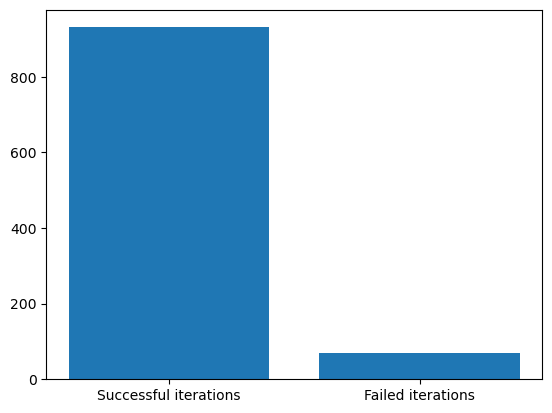

In [5]:
# Bar chart that shows how many iterations were successful in the experiment
plt.bar(["Successful iterations", "Failed iterations"], experimentStatistic.Success.value_counts())

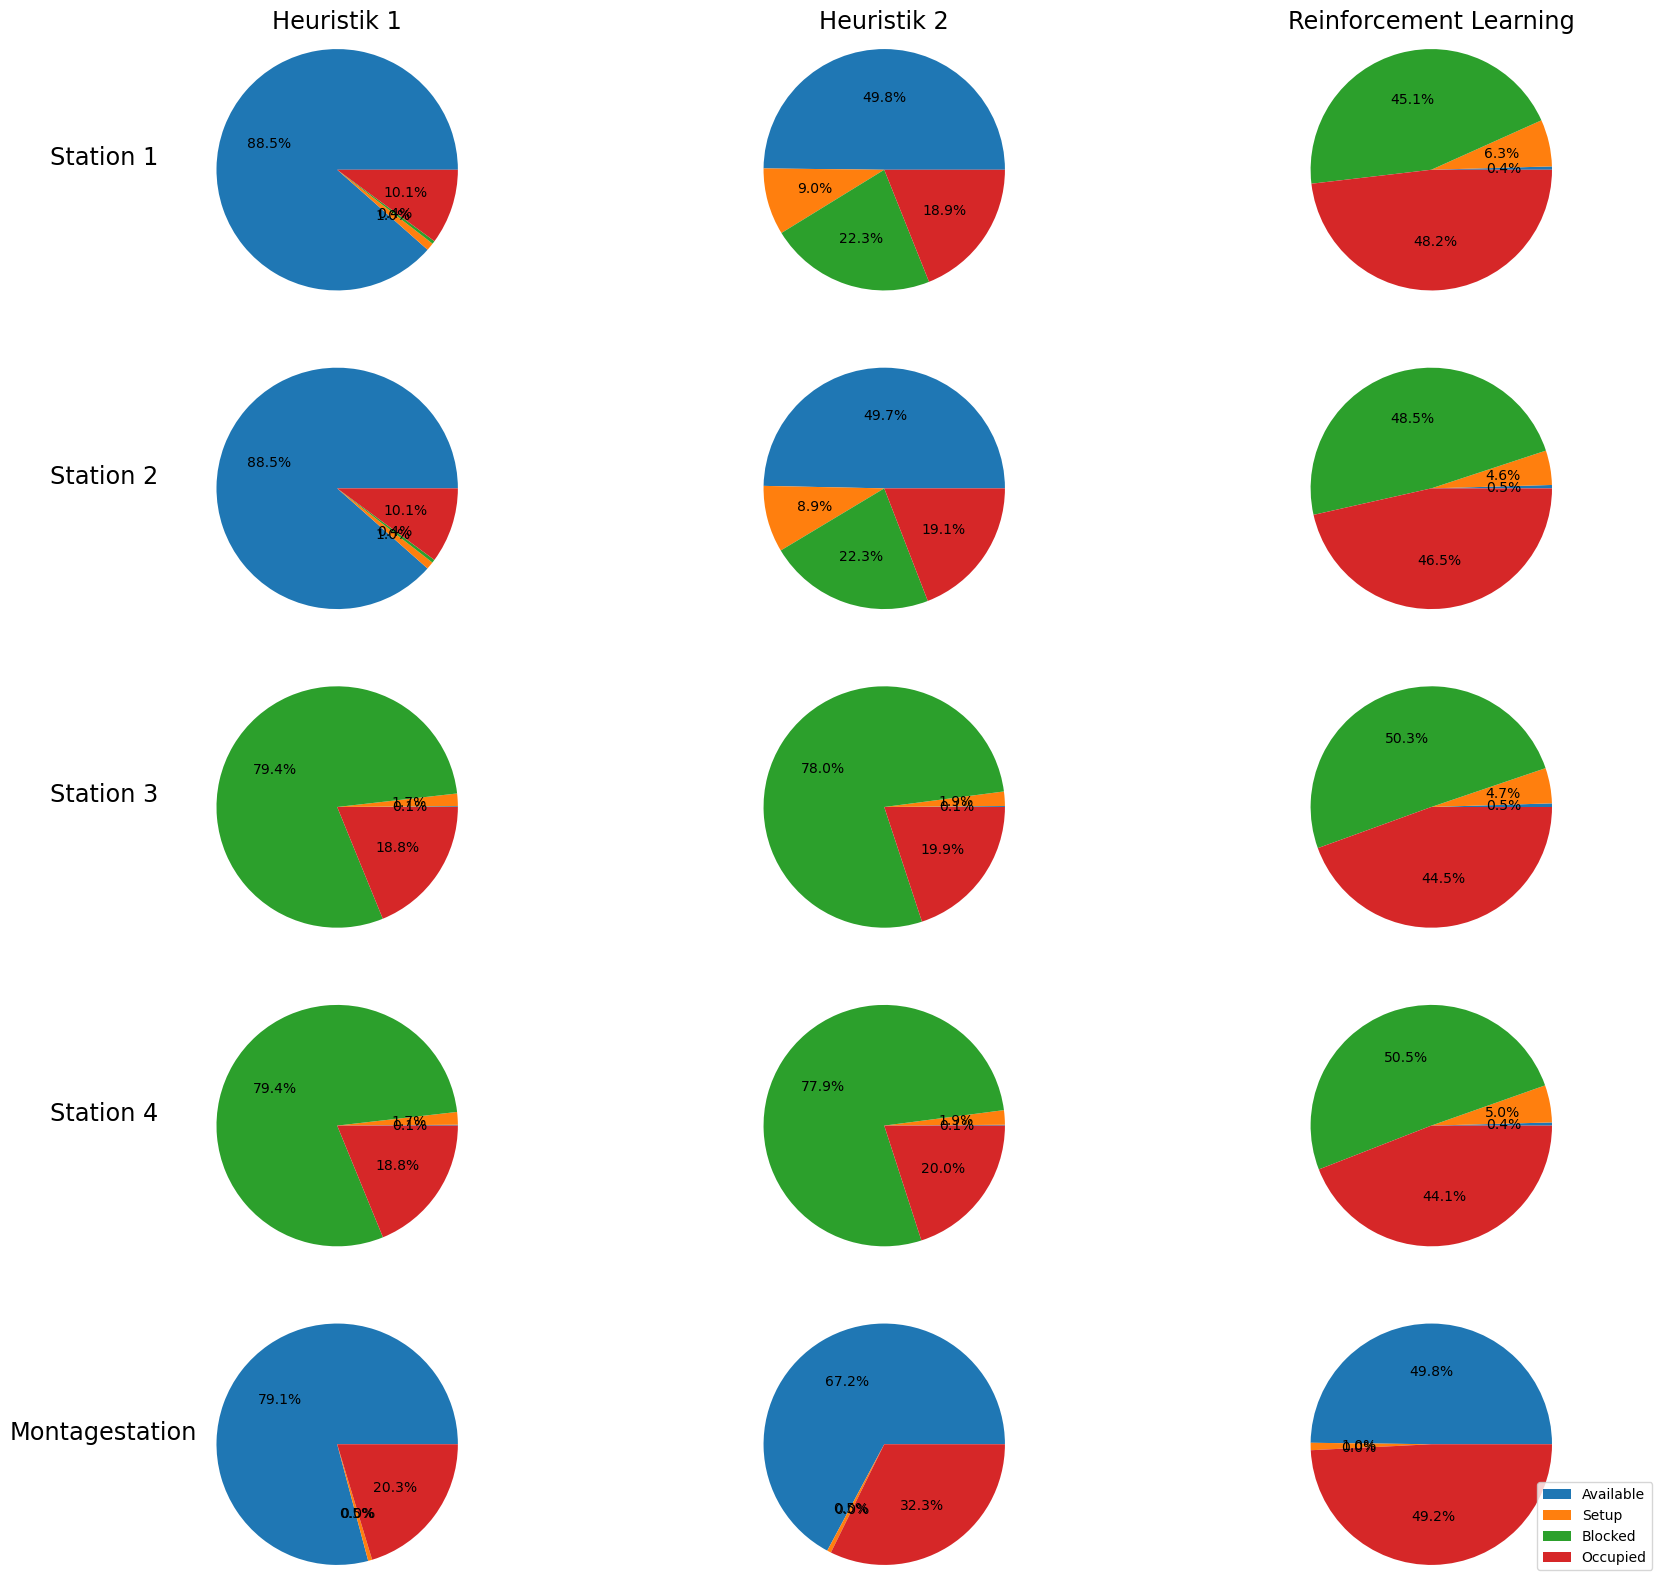

In [6]:
# Set of pie charts depicting how the stations were used throughout the experiments.
fig, axes = plt.subplots(5,3, figsize=(20,20))
cols = ["Heuristik 1", "Heuristik 2", "Reinforcement Learning"]
for ax, col in zip(axes[0], cols):
    ax.set_title(col, size="xx-large")

for i, stationsEl in enumerate(stations):
    if i == 0:
        for ax, row in zip(axes[:,0], stationsEl.Name.unique().tolist()):
            ax.set_ylabel(row, rotation=0, size="xx-large")
    for j, stationName in enumerate(stationsEl.Name.unique().tolist()):
        current = stationsEl[stationsEl.Name == stationName].iloc[:, 1:]
        avg = [current.Available.mean(), current.Setup.mean(), current.Blocked.mean(), current.Occupied.mean()]
        axes[j, i].pie(avg, labels=current.columns.to_list(), autopct='%1.1f%%', labeldistance=None)
        axes[j, i].axis('equal')

plt.legend(loc="lower right")
plt.show()

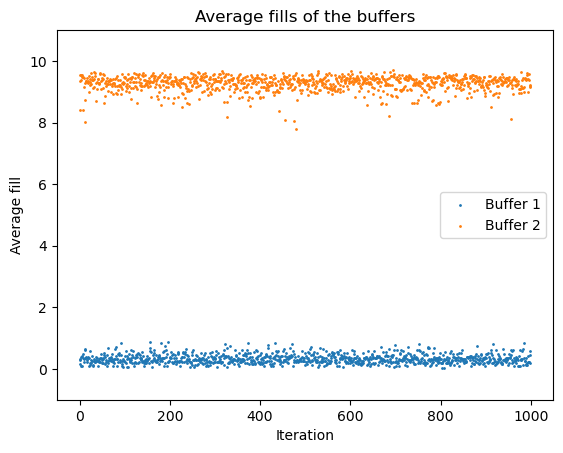

In [7]:
# Scatter plot that plots the average fill of the buffers in relation to one another
bufferNames = bufferStatistic.Name.unique().tolist()[::-1]
for bufferName in bufferNames:
    current = bufferStatistic[bufferStatistic.Name == bufferName].iloc[:, 1:]
    current = current.reset_index(drop=True)
    plt.scatter(current.index, current, s=1)
    plt.ylim(-1, 11)

plt.title("Average fills of the buffers")
plt.ylabel("Average fill")
plt.xlabel("Iteration")
plt.legend(bufferNames)
plt.show()

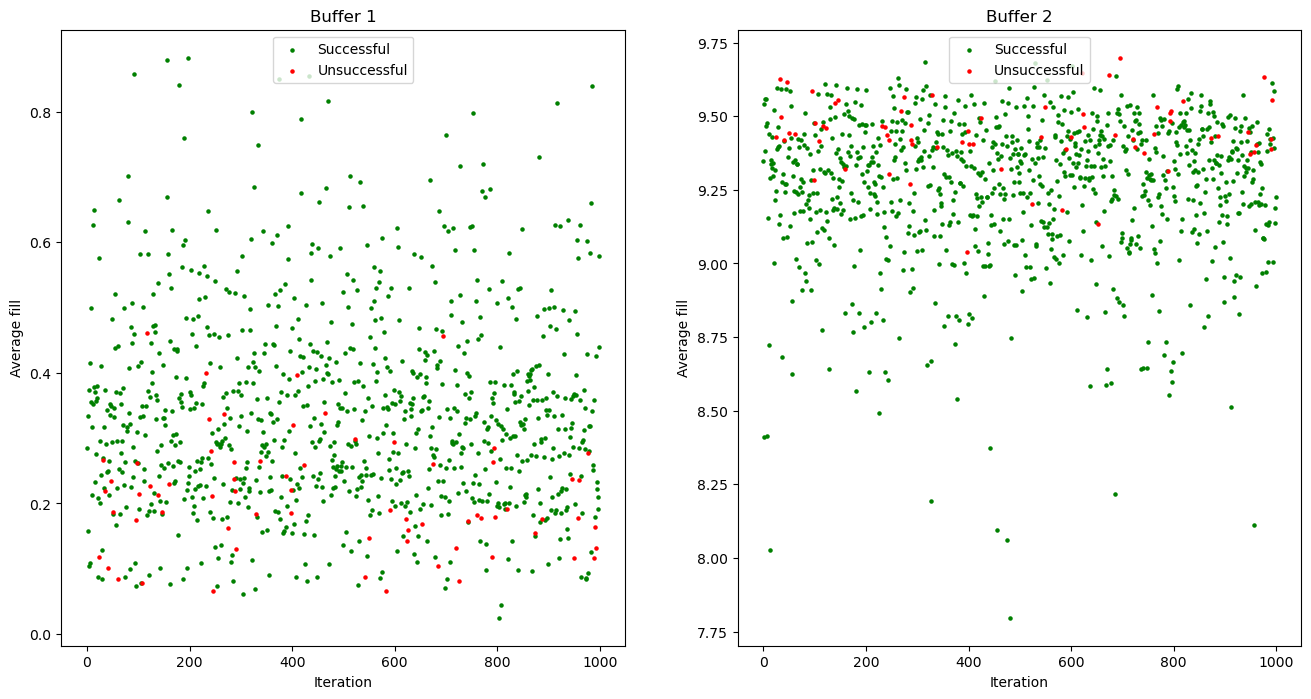

In [8]:
# Set of scatter plots that shows the average fill of the buffers separately
bufferNames = bufferStatistic.Name.unique().tolist()[::-1]
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
for i, bufferName in enumerate(bufferNames):
    current = bufferStatistic[bufferStatistic.Name == bufferName].iloc[:, 1:]
    current = current.reset_index(drop=True)
    successful = current[experimentStatistic.Success]
    unsuccessful = current[~experimentStatistic.Success]
    ax[i].scatter(successful.index, successful, color="green", s=5)
    ax[i].scatter(unsuccessful.index, unsuccessful, color="red", s=5)
    ax[i].set_title(bufferName)
    ax[i].set_ylabel("Average fill")
    ax[i].set_xlabel("Iteration")
    ax[i].legend(["Successful", "Unsuccessful"], loc="upper center")
plt.show()

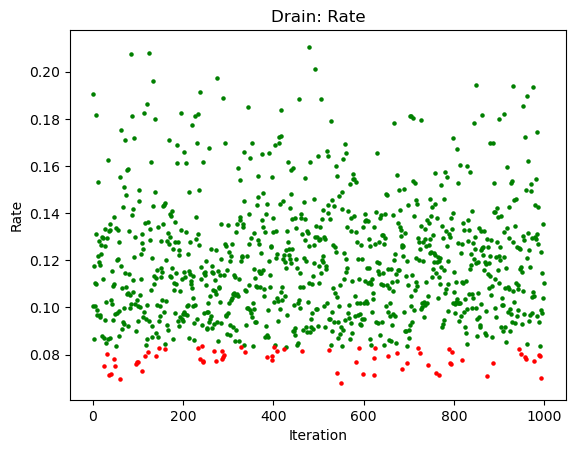

In [9]:
# Scatter plot visualizes the average rate of products arriving in the drain
current = drainStatistic.iloc[:, 1:]
successful = current[experimentStatistic.Success]
unsuccessful = current[~experimentStatistic.Success]
plt.scatter(successful.index, successful.Drainrate, color="green", s=5)
plt.scatter(unsuccessful.index, unsuccessful.Drainrate, color="red", s=5)

plt.title("Drain: Rate")
plt.ylabel("Rate")
plt.xlabel("Iteration")
plt.show()

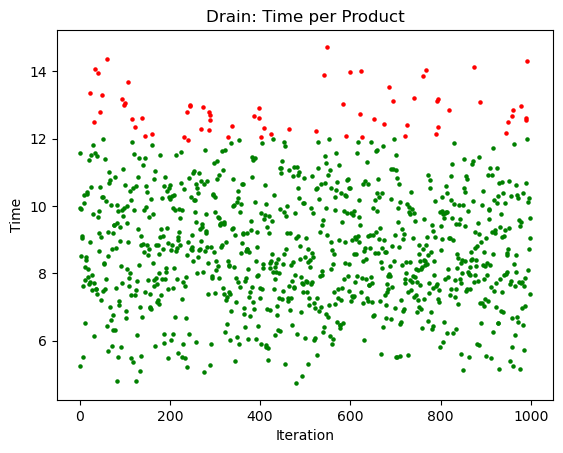

In [10]:
# This scatter plot shows the average time between two products arriving in the drain (reciprocal value of rate)
current = drainStatistic.iloc[:, 1:]
successful = current[experimentStatistic.Success]
unsuccessful = current[~experimentStatistic.Success]
plt.scatter(successful.index, successful["Time per Product"], color="green", s=5)
plt.scatter(unsuccessful.index, unsuccessful["Time per Product"], color="red", s=5)

plt.title("Drain: Time per Product")
plt.ylabel("Time")
plt.xlabel("Iteration")
plt.show()